In [ ]:
''' 
  The Term Project Begins. Will add project description here later

'''

# **Import Libraries**

In [1]:
# Libraries to install
!pip install nsepy

  Created wheel for nsepy: filename=nsepy-0.8-cp36-none-any.whl size=36085 sha256=7d79a8e31838f1dbc5cbb3efb499f7d60919729703f4df7b1f6a4b0a259dd2d7
  Stored in directory: /root/.cache/pip/wheels/05/2c/72/5324e267426eea65dec0c21a12a48b15887c0cf686c7a8fe11
Successfully built nsepy


In [26]:
# Packages to import
from nsepy import get_history as gh
import datetime as dt
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from google.colab import files

# **LSTM Model based Prediction**
For Jupyter notebook, load data from NSEpy library.\
For Google Collab, load data pre-extracted from NSEpy in .csv file

In [17]:
  '''
=====ATTENTION=====
nsepy.get_history gets caught in a infinite loop in google collab but works perfectly in local host Jupyter notebook.
So for google colab, we import data from a csv file created fro/m the same data on a Jupyter Notebook
===================
'''
# # For Jupyter Notebook only. Skip this cell for Google colab
# # Import data from NSEpy
# start_date = dt.datetime(2015,1,1)
# end_date = dt.datetime(2020,8,31)
# data = gh(symbol='RELIANCE',start = start_date, end = end_date)

'\n=====ATTENTION=====\nnsepy.get_history gets caught in a infinite loop in google collab but works perfectly in local host Jupyter notebook.\nSo for google colab, we import data from a csv file created fro/m the same data on a Jupyter Notebook\n===================\n'

In [18]:
# For Google collab, import data from github
data = pd.read_csv('https://raw.githubusercontent.com/adityajaas/CS771A_term_project/master/RELIANCE.csv')
data.set_index(pd.Index(np.linspace(1, len(data.index), len(data.index), dtype = int)))
data['Date']= pd.to_datetime(data['Date']) 
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,RELIANCE,EQ,891.15,886.3,892.00,883.65,888.00,887.90,887.62,677439,6.013059e+13,16263,286377,0.4227
1,2015-01-02,RELIANCE,EQ,887.90,888.1,896.05,884.30,884.95,885.55,889.39,1675827,1.490461e+14,31269,1048543,0.6257
2,2015-01-05,RELIANCE,EQ,885.55,885.0,890.90,874.10,875.55,875.85,881.88,2309591,2.036781e+14,67035,1393132,0.6032
3,2015-01-06,RELIANCE,EQ,875.85,870.0,873.00,832.00,832.50,836.10,847.60,4258043,3.609133e+14,120767,2353273,0.5527
4,2015-01-07,RELIANCE,EQ,836.10,837.1,858.80,837.00,858.00,854.30,849.81,4736315,4.024972e+14,125939,2885468,0.6092


Visualising the stock price data of Reliance Industries Limited (**RELIANCE**) from **January 2015** to **August 2020**. Data is plotted for the day's close price.

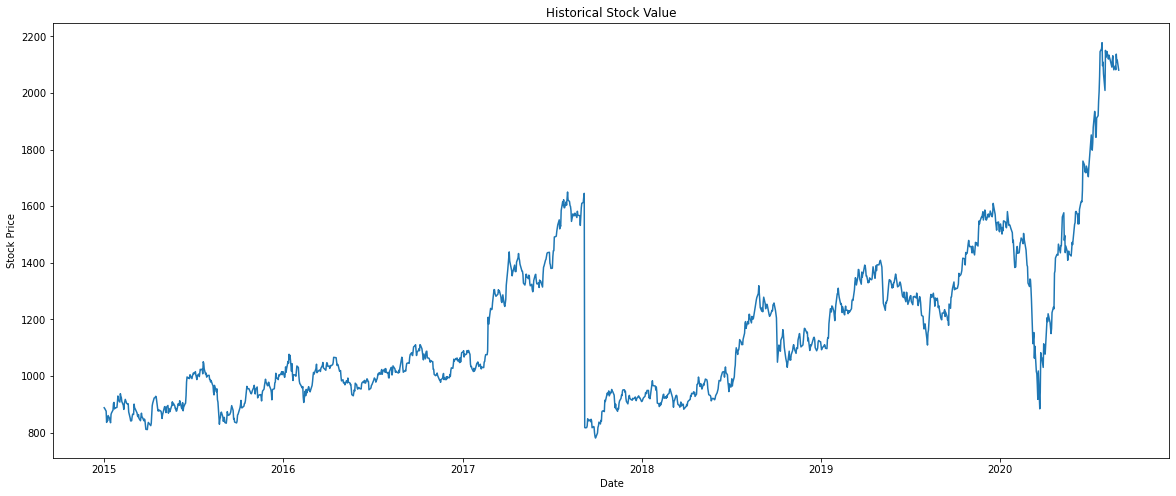

In [19]:
# Visualize the plot
plt.figure(figsize=(20,8))
plt.plot(data['Date'],data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

Processing the raw data to only include relevant columns in the final dataframe. Relevant columns are Date of observaton, Open price, Highest price of the day, Lowest price of the day, Close price.

In [20]:
# Create new dataframe with only relevant columns
stk_data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
stk_data['Date'] = data['Date']
stk_data['Open'] = data['Open']
stk_data['High'] = data['High']
stk_data['Low'] = data['Low']
stk_data['Close'] = data['Close']
stk_data.head()

,Date,Open,High,Low,Close
0,2015-01-01,886.3,892.00,883.65,887.90
1,2015-01-02,888.1,896.05,884.30,885.55
2,2015-01-05,885.0,890.90,874.10,875.85
3,2015-01-06,870.0,873.00,832.00,836.10
4,2015-01-07,837.1,858.80,837.00,854.30


After the data is cleaned, we proceed by splitting it in the ratio of 4:1 for training and testing the model respectively. After splitting, the data is normalized using its mean and standard deviation.

In [21]:
# Define the training set
percent_training: float = 0.80
num_training_samples = int(np.ceil(percent_training*len(stk_data))) # number of training samples in int
training_set = stk_data.iloc[:num_training_samples, 4:5].values # Extract the Close values for training data

#Define the test data
num_testing_samples: int = len(stk_data) - num_training_samples # number of test samples in int 
testing_set = stk_data.iloc[-num_testing_samples:, 4:5].values # Extract the Close values for test data

In [22]:
# Scale training data
scaler = StandardScaler() # MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set) #2D (num_training_samples, 1)
testing_set_scaled = scaler.transform(testing_set) # 2D ndarray (num_testing_samples, 1)

In [23]:
# Create [X]_train, [X]_test and [Y]_train, [Y]_test for model training and testing

sequence_length: int = 64 # Number of x_i for each y_i

x_train = np.array([training_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(training_set_scaled))]) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 3D training set (num_training_samples, sequence_length, 1) 

x_test = np.array([testing_set_scaled[i - sequence_length:i, 0] for i in range(sequence_length, len(testing_set_scaled))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #3D test set (num_testing_samples, sequence_length, 1)

y_train = np.array([training_set_scaled[i, 0] for i in range(sequence_length, len(training_set_scaled))]) # 2D (num_training_samples, 1)
y_test = np.array([testing_set_scaled[i, 0] for i in range(sequence_length, len(testing_set_scaled))]) # 2D (num_testing_samples, 1)
y_test = np.reshape(y_test, (y_test.shape[0])) # 1D (num_testing_samples, )

print('x_train shape:', x_train.shape, '\n', 'x_test shape:', x_test.shape, '\n', 'y_train shape:', y_train.shape, '\n', 'y_test shape:', y_test.shape)

x_train shape: (1057, 64, 1) 
 x_test shape: (216, 64, 1) 
 y_train shape: (1057,) 
 y_test shape: (216,)


#**Model Training**

In [11]:
# Build LSTM Model
epochs: int = 100
batch_size: int = 32

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences = False),
  tf.keras.layers.Dropout(0.15),
  #tf.keras.layers.LSTM(64, return_sequences = False),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dense(1),
])
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', 
             optimizer = 'adam', 
             )

# Early Stopping
# Check at end of every epoch whether the loss is no longer decreasing, considering the min_delta (0 by default) and patience if applicable. 
# Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, # Shows progress of each epoch
                               patience = 15, # Check for 9 more iterations after loss decrement stalls
                               restore_best_weights = False
                               )
# Loss history
loss_history = model.fit(x_train,
          y_train,
          epochs = epochs, 
          batch_size = batch_size,
          verbose = 2, 
          validation_split = 0.20,
          # validation_data = (x_test, y_test),
          callbacks = [early_stopping],
          )

model.summary() # Get model summary
loss = model.evaluate(x_test, y_test, batch_size = batch_size) # Evaluate model on test data

# early_stopping.stopped_epoch returns 0 if training didn't stop early.
if early_stopping.stopped_epoch != 0:
  print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

Epoch 1/100
27/27 - 1s - loss: 0.2871 - val_loss: 0.0449
Epoch 2/100
27/27 - 1s - loss: 0.1068 - val_loss: 0.0386
Epoch 3/100
27/27 - 1s - loss: 0.0878 - val_loss: 0.0270
Epoch 4/100
27/27 - 1s - loss: 0.0607 - val_loss: 0.0251
Epoch 5/100
27/27 - 1s - loss: 0.0740 - val_loss: 0.0244
Epoch 6/100
27/27 - 1s - loss: 0.0704 - val_loss: 0.0437
Epoch 7/100
27/27 - 1s - loss: 0.0586 - val_loss: 0.0340
Epoch 8/100
27/27 - 1s - loss: 0.0634 - val_loss: 0.0411
Epoch 9/100
27/27 - 1s - loss: 0.0691 - val_loss: 0.0279
Epoch 10/100
27/27 - 1s - loss: 0.0618 - val_loss: 0.0344
Epoch 11/100
27/27 - 1s - loss: 0.0591 - val_loss: 0.0253
Epoch 12/100
27/27 - 1s - loss: 0.0530 - val_loss: 0.0209
Epoch 13/100
27/27 - 1s - loss: 0.0523 - val_loss: 0.0279
Epoch 14/100
27/27 - 1s - loss: 0.0490 - val_loss: 0.0308
Epoch 15/100
27/27 - 1s - loss: 0.0675 - val_loss: 0.0200
Epoch 16/100
27/27 - 1s - loss: 0.0549 - val_loss: 0.0190
Epoch 17/100
27/27 - 1s - loss: 0.0544 - val_loss: 0.0392
Epoch 18/100
27/27 - 1s

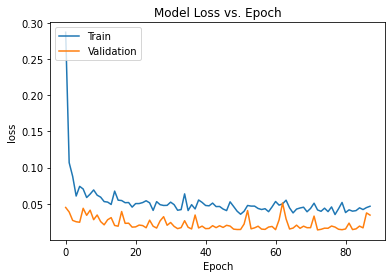

In [12]:
plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Prediction**

In [13]:
training_prediction = model.predict(x_train)
training_prediction = scaler.inverse_transform(training_prediction) # Get back data in unscaled (not normalized) data

train_dates = stk_data['Date'][sequence_length: sequence_length + x_train.shape[0]]

In [14]:
test_prediction = model.predict(x_test)

y_test2 = np.reshape(y_test, (y_test.shape[0], 1))

test_dates = stk_data['Date'][-x_test.shape[0]:]

Gaps in prediction line since model requires minimum sequence length of input to predict
The MSE loss for test data: 0.43151714815766634


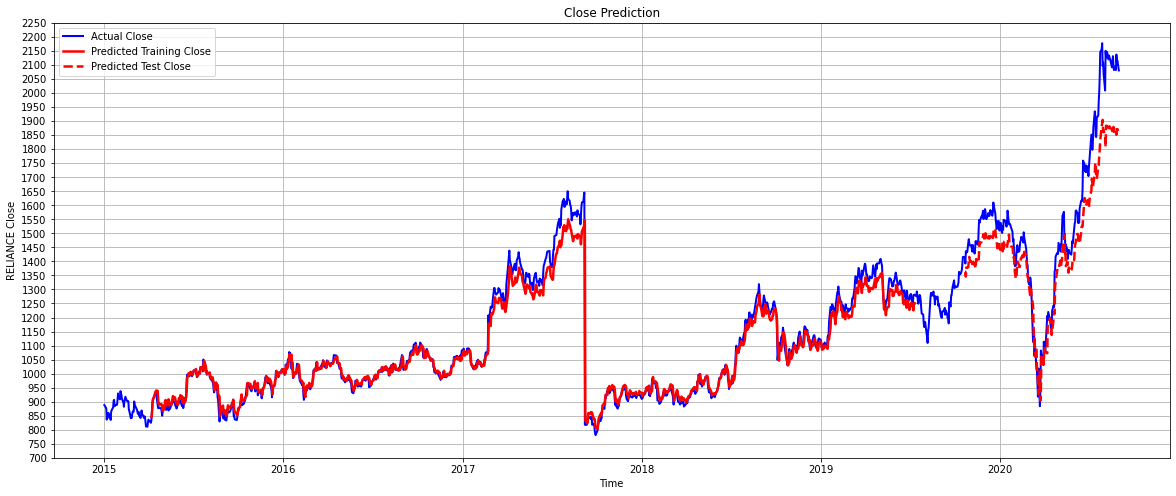

In [15]:
print('Gaps in prediction line since model requires minimum sequence length of input to predict')

assert y_test2.shape == test_prediction.shape
print('The MSE loss for test data:', sklearn.metrics.mean_squared_error(y_test2,test_prediction))

test_prediction = scaler.inverse_transform(test_prediction) # Get back data in unscaled (not normalized) data
y_test2 = scaler.inverse_transform(y_test2) # Get back data in unscaled (not normalized) data

# Visualizing test results
plt.figure(figsize=(20,8))

plt.plot(data['Date'],data['Close'],'-', linewidth = 2, color = 'blue', label = 'Actual Close')

plt.plot(train_dates, training_prediction, '-', linewidth = 2.5 ,color = 'red', label = 'Predicted Training Close')
plt.plot(test_dates, test_prediction, '--', linewidth = 2.5 ,color = 'red', label = 'Predicted Test Close')

ax = plt.gca()

plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('RELIANCE Close')
plt.yticks(np.arange(700, 2300, 50))
plt.grid(True, which= 'both')
plt.legend()
plt.show()

# **MISCELLANEOUS**

Epoch 1/150
27/27 - 1s - loss: 0.1766 - val_loss: 0.0473
Epoch 2/150
27/27 - 1s - loss: 0.0806 - val_loss: 0.0421
Epoch 3/150
27/27 - 1s - loss: 0.0735 - val_loss: 0.0264
Epoch 4/150
27/27 - 1s - loss: 0.0631 - val_loss: 0.0313
Epoch 5/150
27/27 - 1s - loss: 0.0617 - val_loss: 0.0259
Epoch 6/150
27/27 - 1s - loss: 0.0504 - val_loss: 0.0233
Epoch 7/150
27/27 - 1s - loss: 0.0571 - val_loss: 0.0224
Epoch 8/150
27/27 - 1s - loss: 0.0518 - val_loss: 0.0305
Epoch 9/150
27/27 - 1s - loss: 0.0504 - val_loss: 0.0250
Epoch 10/150
27/27 - 1s - loss: 0.0520 - val_loss: 0.0211
Epoch 11/150
27/27 - 1s - loss: 0.0484 - val_loss: 0.0244
Epoch 12/150
27/27 - 1s - loss: 0.0383 - val_loss: 0.0211
Epoch 13/150
27/27 - 1s - loss: 0.0556 - val_loss: 0.0200
Epoch 14/150
27/27 - 1s - loss: 0.0450 - val_loss: 0.0194
Epoch 15/150
27/27 - 1s - loss: 0.0386 - val_loss: 0.0195
Epoch 16/150
27/27 - 1s - loss: 0.0435 - val_loss: 0.0273
Epoch 17/150
27/27 - 1s - loss: 0.0404 - val_loss: 0.0192
Epoch 18/150
27/27 - 1s

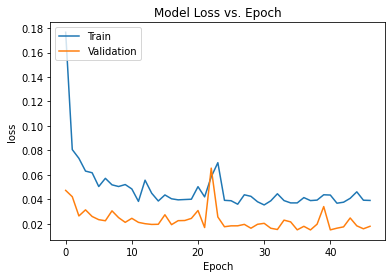

Gaps in prediction line since model requires minimum sequence length of input to predict
The MSE loss for test data: 0.11512710506080447


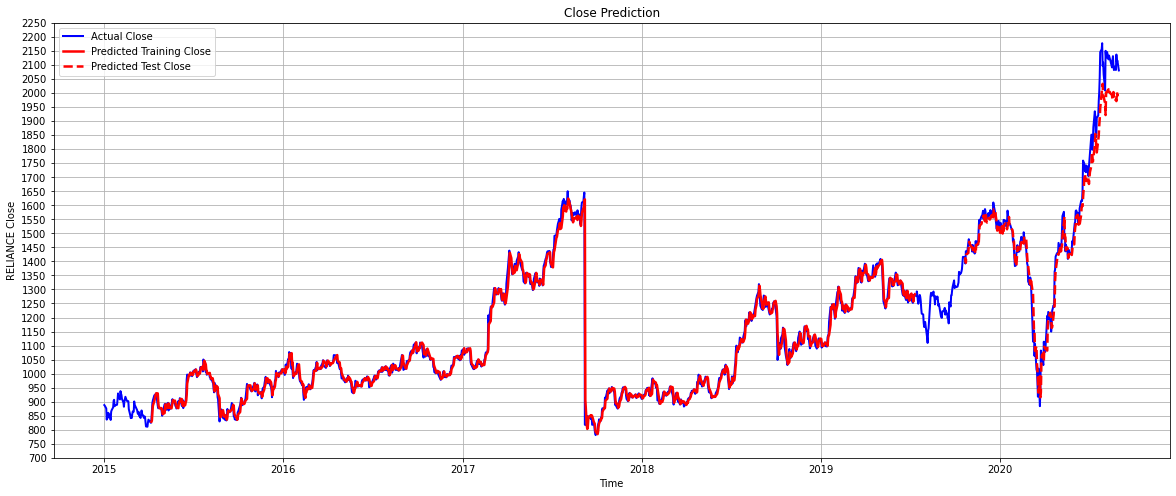

In [24]:

# Build LSTM Model
epochs: int = 150
batch_size: int = 32

#LSTM_1 = LSTM(units = 32, #initially 5
#    activation = 'relu', #initially tanh
#   input_shape = (x_train.shape[1], 1),
#   return_sequences = False,
#   )
# LSTM_2 = LSTM(
#     units = 10,
#     input_shape = ( sequence_length, 5)
#     )
#model = Sequential()
#model.add(LSTM_1) # Output shape: (batch_size, sequence_length, units)
#model.add(Dropout(0.4))
# model.add(LSTM_2) # Output shape: 
# model.add(Dropout(0.2))
model = tf.keras.models.Sequential([
  #tf.keras.layers.LSTM(32, return_sequences=True),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dense(1),
])
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', 
             optimizer = 'adam', 
             )

# Early Stopping
# Check at end of every epoch whether the loss is no longer decreasing, considering the min_delta (0 by default) and patience if applicable. 
# Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, # Shows progress of each epoch
                               patience = 9, # Check for 9 more iterations after loss decrement stalls
                               restore_best_weights = True
                               )
# Loss history
loss_history = model.fit(x_train,
          y_train,
          epochs = epochs, 
          batch_size = batch_size,
          verbose = 2, 
          validation_split = 0.20,
          # validation_data = (x_test, y_test),
          callbacks = [early_stopping],
          )

model.summary() # Get model summary
loss = model.evaluate(x_test, y_test, batch_size = batch_size) # Evaluate model on test data

# early_stopping.stopped_epoch returns 0 if training didn't stop early.
if early_stopping.stopped_epoch != 0:
  print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

#############################################################################################

plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#############################################################################################

training_prediction = model.predict(x_train)
training_prediction = scaler.inverse_transform(training_prediction) # Get back data in unscaled (not normalized) data

train_dates = stk_data['Date'][sequence_length: sequence_length + x_train.shape[0]]

test_prediction = model.predict(x_test)

y_test2 = np.reshape(y_test, (y_test.shape[0], 1))

test_dates = stk_data['Date'][-x_test.shape[0]:]

#############################################################################################

print('Gaps in prediction line since model requires minimum sequence length of input to predict')

assert y_test2.shape == test_prediction.shape
print('The MSE loss for test data:', sklearn.metrics.mean_squared_error(y_test2,test_prediction))

test_prediction = scaler.inverse_transform(test_prediction) # Get back data in unscaled (not normalized) data
y_test2 = scaler.inverse_transform(y_test2) # Get back data in unscaled (not normalized) data

# Visualizing test results
plt.figure(figsize=(20,8))

plt.plot(data['Date'],data['Close'],'-', linewidth = 2, color = 'blue', label = 'Actual Close')

plt.plot(train_dates, training_prediction, '-', linewidth = 2.5 ,color = 'red', label = 'Predicted Training Close')
plt.plot(test_dates, test_prediction, '--', linewidth = 2.5 ,color = 'red', label = 'Predicted Test Close')

ax = plt.gca()

plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('RELIANCE Close')
plt.yticks(np.arange(700, 2300, 50))
plt.grid(True, which= 'both')
plt.legend()
plt.show()

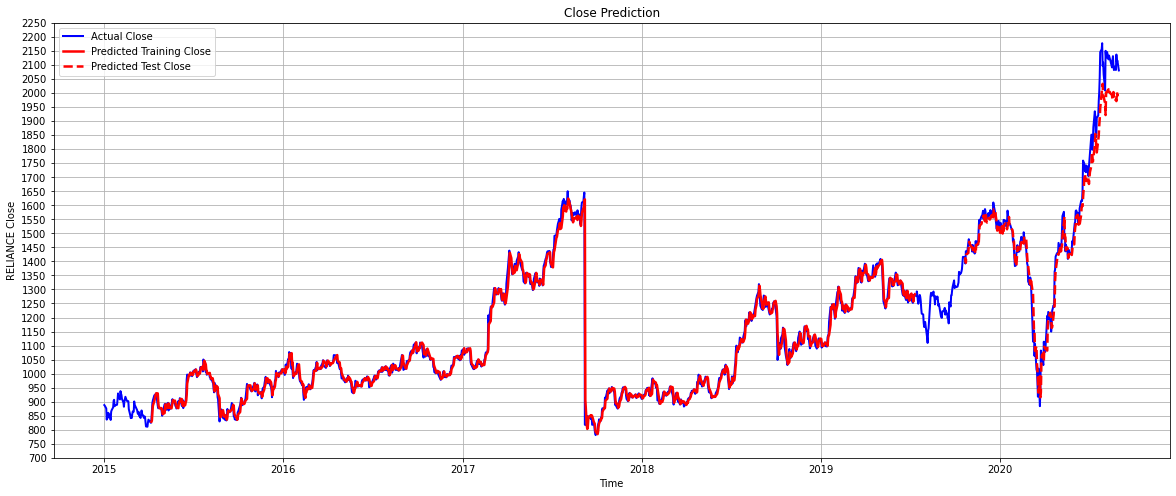

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(20,8))

plt.plot(data['Date'],data['Close'],'-', linewidth = 2, color = 'blue', label = 'Actual Close')

plt.plot(train_dates, training_prediction, '-', linewidth = 2.5 ,color = 'red', label = 'Predicted Training Close')
plt.plot(test_dates, test_prediction, '--', linewidth = 2.5 ,color = 'red', label = 'Predicted Test Close')

ax = plt.gca()

plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('RELIANCE Close')
plt.yticks(np.arange(700, 2300, 50))
plt.grid(True, which= 'both')
plt.legend()
plt.show()
plt.savefig('lstm_prediction.png')

files.download('lstm_prediction.png')

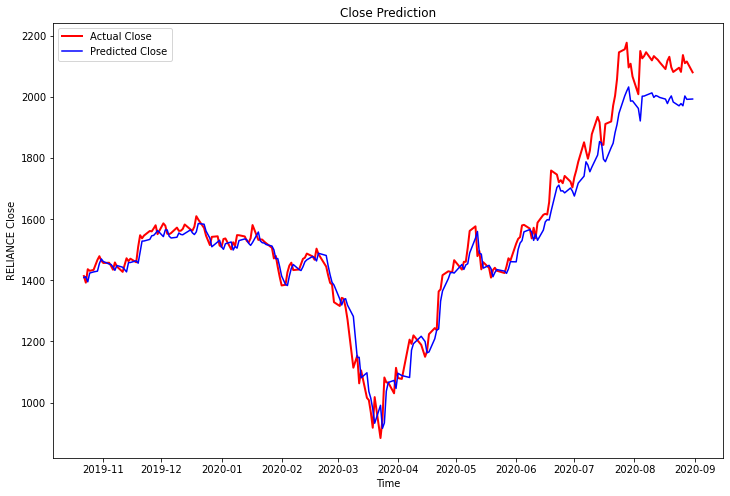

In [25]:
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction) # Get back data in unscaled (not normalized) data

y_test2 = np.reshape(y_test, (y_test.shape[0], 1))
y_test = scaler.inverse_transform(y_test2) # Get back data in unscaled (not normalized) data

test_dates = stk_data['Date'][-x_test.shape[0]:]

#############################################################################################

# Visualizing test results
#print('The MSE loss for test data:', sklearn.metrics.mean_squared_error(y_test2,test_prediction))

plt.figure(figsize=(12,8))
plt.plot_date(test_dates, y_test, '-', linewidth = 2, color = 'red', label = 'Actual Close')
plt.plot(test_dates, prediction, color = 'blue', label = 'Predicted Close')
plt.title('Close Prediction')
plt.xlabel('Time')
plt.ylabel('RELIANCE Close')
plt.legend()
plt.show()